# [EX-06] 네이버 영화리뷰 감성분석
## 오늘의 루브릭
### 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. - 3가지 이상의 모델이 성공적으로 시도됨
### 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 적절히 분석함
### 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함

### 심볼릭 링크 연결하기
ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [1]:
import pandas as pd

from konlpy.tag import Mecab
import numpy as np
from collections import Counter

import tensorflow as tf

import matplotlib.pyplot as plt

import os

from gensim.models.keyedvectors import Word2VecKeyedVectors

import gensim
from gensim.models import KeyedVectors

from tensorflow.keras.initializers import Constant

print("필요한 import 완료!")

필요한 import 완료!


## 1) 데이터 준비와 확인

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

print("데이터 읽기 완료!")

데이터 읽기 완료!


In [3]:
#학습 데이터 확인!
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
#시험 데이터 완료!
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [5]:
#학습 데이터와 시험 데이터의 갯수 확인!
print(len(train_data))
print(len(test_data))

150000
50000


## 2) 데이터로더 구성

In [6]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) #한국어 토크나이저로 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] #불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<PAD>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [7]:
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [8]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [9]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [10]:
#1번째 리뷰데이터의 라벨 확인하기
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  

더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


## 3) 모델 구성을 위한 데이터 분석 및 가공

In [11]:
total_data_text = list(X_train) + list(X_test)

num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


In [12]:
#keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가
x_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

x_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(x_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성
## 5) 모델 훈련 개시
## 6) Loss, Accuracy 그래프 시각화
## 7) 학습된 Embedding 레이어 분석

## 1.RNN모델 사용

In [13]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(8))  
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         2000000   
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 6688      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 2,006,769
Trainable params: 2,006,769
Non-trainable params: 0
_________________________________________________________________


In [14]:
# validation set 10000건 분리

x_val = x_train[:10000]   
y_val = y_train[:10000]

# validation set을 제외한 나머지 15000건
partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [15]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 5s 8ms/step - loss: 0.5081 - accuracy: 0.7262 - val_loss: 0.3602 - val_accuracy: 0.8449
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3335 - accuracy: 0.8595 - val_loss: 0.3367 - val_accuracy: 0.8546
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2996 - accuracy: 0.8738 - val_loss: 0.3383 - val_accuracy: 0.8549
Epoch 4/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2739 - accuracy: 0.8852 - val_loss: 0.3446 - val_accuracy: 0.8546
Epoch 5/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2504 - accuracy: 0.8962 - val_loss: 0.3524 - val_accuracy: 0.8570


In [16]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3536 - accuracy: 0.8531
[0.3535741865634918, 0.8531439900398254]


In [17]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


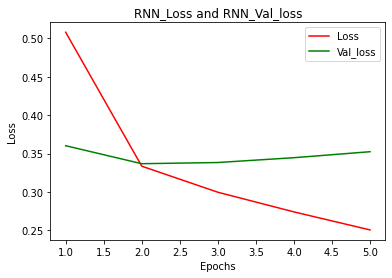

In [18]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'g', label='Val_loss')
plt.title('RNN_Loss and RNN_Val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

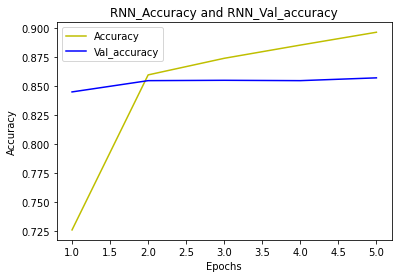

In [19]:
plt.clf()#그림을 초기화합니다

plt.plot(epochs, acc, 'y', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('RNN_Accuracy and RNN_Val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 2.1-D CNN 모델 사용

In [20]:
vocab_size = 10000
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          22416     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [21]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [22]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 4s 8ms/step - loss: 0.4515 - accuracy: 0.7712 - val_loss: 0.3373 - val_accuracy: 0.8527
Epoch 2/5
266/266 [==============================] - 2s 6ms/step - loss: 0.3058 - accuracy: 0.8727 - val_loss: 0.3235 - val_accuracy: 0.8604
Epoch 3/5
266/266 [==============================] - 2s 6ms/step - loss: 0.2496 - accuracy: 0.9007 - val_loss: 0.3334 - val_accuracy: 0.8597
Epoch 4/5
266/266 [==============================] - 2s 6ms/step - loss: 0.1846 - accuracy: 0.9312 - val_loss: 0.3739 - val_accuracy: 0.8508
Epoch 5/5
266/266 [==============================] - 2s 6ms/step - loss: 0.1249 - accuracy: 0.9571 - val_loss: 0.4305 - val_accuracy: 0.8469


In [23]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4444 - accuracy: 0.8423
[0.444351464509964, 0.842321515083313]


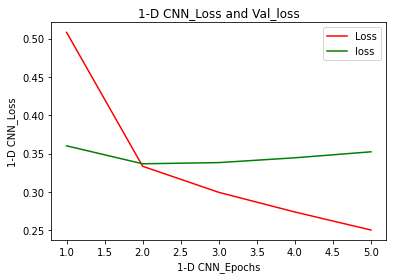

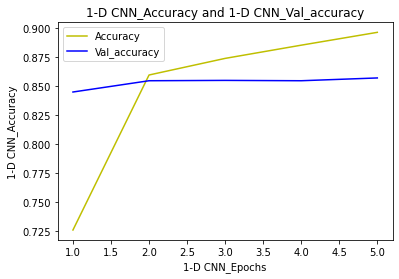

In [24]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'g', label='loss')
plt.title('1-D CNN_Loss and Val_loss')
plt.xlabel('1-D CNN_Epochs')
plt.ylabel('1-D CNN_Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'y', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('1-D CNN_Accuracy and 1-D CNN_Val_accuracy')
plt.xlabel('1-D CNN_Epochs')
plt.ylabel('1-D CNN_Accuracy')
plt.legend()

plt.show()

## 3.GlobalMaxPooling1D 레이어 1개 있는 모델

In [25]:
vocab_size = 10000
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 200)         2000000   
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 2,001,617
Trainable params: 2,001,617
Non-trainable params: 0
_________________________________________________________________


In [26]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/5
266/266 [==============================] - 2s 5ms/step - loss: 0.4582 - accuracy: 0.8120 - val_loss: 0.3427 - val_accuracy: 0.8501
Epoch 2/5
266/266 [==============================] - 1s 4ms/step - loss: 0.3104 - accuracy: 0.8689 - val_loss: 0.3297 - val_accuracy: 0.8562
Epoch 3/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2655 - accuracy: 0.8917 - val_loss: 0.3366 - val_accuracy: 0.8563
Epoch 4/5
266/266 [==============================] - 1s 4ms/step - loss: 0.2261 - accuracy: 0.9117 - val_loss: 0.3485 - val_accuracy: 0.8544
Epoch 5/5
266/266 [==============================] - 1s 4ms/step - loss: 0.1859 - accuracy: 0.9313 - val_loss: 0.3735 - val_accuracy: 0.8527


In [28]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3852 - accuracy: 0.8480
[0.3851524889469147, 0.8480175733566284]


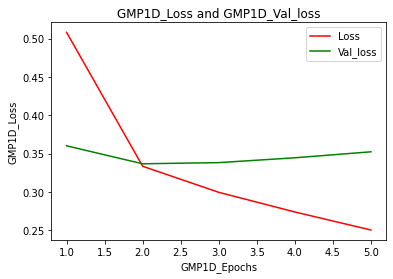

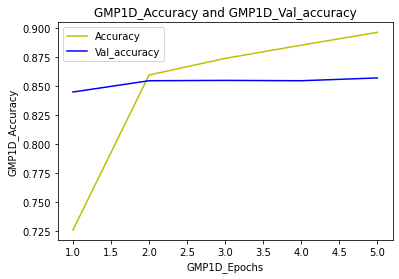

In [29]:
epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Loss')
plt.plot(epochs, val_loss, 'g', label='Val_loss')
plt.title('GMP1D_Loss and GMP1D_Val_loss')
plt.xlabel('GMP1D_Epochs')
plt.ylabel('GMP1D_Loss')
plt.legend()

plt.show()

plt.plot(epochs, acc, 'y', label='Accuracy')
plt.plot(epochs, val_acc, 'b', label='Val_accuracy')
plt.title('GMP1D_Accuracy and GMP1D_Val_accuracy')
plt.xlabel('GMP1D_Epochs')
plt.ylabel('GMP1D_Accuracy')
plt.legend()

plt.show()

In [30]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 200)


In [31]:
# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [32]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("사랑")

[('오랜만', 0.44224095344543457),
 ('켄', 0.3874504864215851),
 ('좋', 0.38610148429870605),
 ('비행기', 0.3600085377693176),
 ('샘', 0.35769686102867126),
 ('맛있', 0.35602015256881714),
 ('만족', 0.35341235995292664),
 ('여운', 0.35154688358306885),
 ('뮤', 0.34515324234962463),
 ('웃', 0.34483602643013)]

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [33]:
#버전확인 #지금은 3.8.3으로 뜨지만 처음에 돌렸을때는 4.몇이었다.
gensim.__version__

'3.8.3'

In [34]:
#버전 낮추기 #지금은 이미 3.8.3이라서 오류가 뜬다

#pip install --upgrade gensim==3.8.3

In [35]:
#다운받은 파일 연결하기
word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)
vector = word2vec["사랑"]
vector     # 무려 300dim의 워드 벡터입니다.

/tmp/ipykernel_3633/1370727866.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  vector = word2vec["사랑"]


array([-1.3740246 , -1.7353463 ,  3.3915305 , -2.569253  , -1.4016607 ,
        1.4556127 ,  0.9414557 ,  1.9207907 ,  0.16471806,  0.4838317 ,
       -0.8547181 ,  2.0879807 ,  0.86741775,  0.87539405, -0.09962013,
        0.22928311, -1.1858722 ,  0.00858838,  1.4999928 , -0.16196461,
       -0.35184434, -0.92390764,  1.0849575 ,  0.3025011 ,  2.7021565 ,
       -1.0263684 ,  0.32864776, -0.76589465, -2.510981  , -0.66225356,
        2.8434615 ,  0.50130975, -1.021874  , -1.4366034 ,  1.1110784 ,
        0.5812605 , -0.5830406 , -0.5785423 ,  1.3634988 ,  2.3074338 ,
       -1.4314893 ,  0.45745876,  1.1073523 , -3.2135262 , -0.2898375 ,
       -1.1622221 ,  1.2369208 , -0.7622987 , -0.37757635,  1.1376442 ,
        0.01065568, -0.69105595,  1.5159112 ,  1.1534518 , -1.0119992 ,
       -0.5757404 ,  1.1349088 , -1.1289831 ,  0.13004152,  2.0451715 ,
       -0.23940353,  1.3604902 ,  0.72700524,  0.32545742,  1.0612459 ,
        0.42252553,  1.1442151 ,  2.8774905 ,  2.4377263 , -1.34

In [36]:
#크기 확인하기
word2vec["사랑"].shape

/tmp/ipykernel_3633/2654163817.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  word2vec["사랑"].shape


(200,)

## 1.성능개선 버전_RNN모델 사용

In [37]:
vocab_size = 10000
word_vector_dim = 200
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec:
        embedding_matrix[i] = word2vec[index_to_word[i]]

/tmp/ipykernel_3633/3796460438.py:7: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  if index_to_word[i] in word2vec:
/tmp/ipykernel_3633/3796460438.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  embedding_matrix[i] = word2vec[index_to_word[i]]


In [38]:
vocab_size = 10000
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))   # trainable을 True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(32, 7, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(128, 7, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) 

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 35, 32)            44832     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 32)             0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 1, 128)            28800     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 128)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [39]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [40]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=23

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/23
266/266 [==============================] - 3s 9ms/step - loss: 0.5086 - accuracy: 0.7409 - val_loss: 0.3995 - val_accuracy: 0.8181
Epoch 2/23
266/266 [==============================] - 2s 7ms/step - loss: 0.3584 - accuracy: 0.8427 - val_loss: 0.3491 - val_accuracy: 0.8423
Epoch 3/23
266/266 [==============================] - 2s 7ms/step - loss: 0.3043 - accuracy: 0.8703 - val_loss: 0.3389 - val_accuracy: 0.8488
Epoch 4/23
266/266 [==============================] - 2s 7ms/step - loss: 0.2684 - accuracy: 0.8891 - val_loss: 0.3422 - val_accuracy: 0.8493
Epoch 5/23
266/266 [==============================] - 2s 7ms/step - loss: 0.2405 - accuracy: 0.9028 - val_loss: 0.3515 - val_accuracy: 0.8482
Epoch 6/23
266/266 [==============================] - 2s 7ms/step - loss: 0.2143 - accuracy: 0.9152 - val_loss: 0.3658 - val_accuracy: 0.8505
Epoch 7/23
266/266 [==============================] - 2s 7ms/step - loss: 0.1873 - accuracy: 0.9274 - val_loss: 0.3937 - val_accuracy: 0.8480
Epoch 

In [41]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 1.1102 - accuracy: 0.8320
[1.1101921796798706, 0.832007646560669]


## 2.성능개선 버전_1-D CNN 모델 사용

In [42]:
vocab_size = 10000
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(128))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 1032      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 2,169,489
Trainable params: 2,169,489
Non-trainable params: 0
_________________________________________________________________


In [43]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [44]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=23  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/23
266/266 [==============================] - 5s 14ms/step - loss: 0.5619 - accuracy: 0.6657 - val_loss: 0.3844 - val_accuracy: 0.8285
Epoch 2/23
266/266 [==============================] - 3s 13ms/step - loss: 0.3478 - accuracy: 0.8484 - val_loss: 0.3401 - val_accuracy: 0.8497
Epoch 3/23
266/266 [==============================] - 3s 13ms/step - loss: 0.2961 - accuracy: 0.8741 - val_loss: 0.3312 - val_accuracy: 0.8553
Epoch 4/23
266/266 [==============================] - 3s 13ms/step - loss: 0.2672 - accuracy: 0.8884 - val_loss: 0.3149 - val_accuracy: 0.8622
Epoch 5/23
266/266 [==============================] - 3s 13ms/step - loss: 0.2396 - accuracy: 0.9015 - val_loss: 0.3276 - val_accuracy: 0.8662
Epoch 6/23
266/266 [==============================] - 3s 13ms/step - loss: 0.2166 - accuracy: 0.9124 - val_loss: 0.3206 - val_accuracy: 0.8650
Epoch 7/23
266/266 [==============================] - 3s 13ms/step - loss: 0.1940 - accuracy: 0.9231 - val_loss: 0.3523 - val_accuracy: 0.8599

In [45]:
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7318 - accuracy: 0.8504
[0.7318143248558044, 0.8504180312156677]


## 3.GlobalMaxPooling1D 레이어 1개 있는 모델

In [46]:
vocab_size = 10000
word_vector_dim = 200

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  # 카피한 임베딩을 여기서 활용
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 200)           2000000   
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 200)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               25728     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 2,025,857
Trainable params: 2,025,857
Non-trainable params: 0
_________________________________________________________________


In [47]:
x_val = x_train[:10000]   
y_val = y_train[:10000]

partial_x_train = x_train[10000:]  
partial_y_train = y_train[10000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(136182, 41)
(136182,)


In [48]:
# 학습의 진행
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=23  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/23
266/266 [==============================] - 2s 5ms/step - loss: 0.6327 - accuracy: 0.6446 - val_loss: 0.5618 - val_accuracy: 0.7104
Epoch 2/23
266/266 [==============================] - 1s 4ms/step - loss: 0.5269 - accuracy: 0.7381 - val_loss: 0.5094 - val_accuracy: 0.7521
Epoch 3/23
266/266 [==============================] - 1s 4ms/step - loss: 0.4756 - accuracy: 0.7730 - val_loss: 0.4661 - val_accuracy: 0.7789
Epoch 4/23
266/266 [==============================] - 1s 4ms/step - loss: 0.4384 - accuracy: 0.7960 - val_loss: 0.4510 - val_accuracy: 0.7906
Epoch 5/23
266/266 [==============================] - 1s 4ms/step - loss: 0.4092 - accuracy: 0.8142 - val_loss: 0.4247 - val_accuracy: 0.8055
Epoch 6/23
266/266 [==============================] - 1s 4ms/step - loss: 0.3865 - accuracy: 0.8267 - val_loss: 0.4169 - val_accuracy: 0.8134
Epoch 7/23
266/266 [==============================] - 1s 4ms/step - loss: 0.3630 - accuracy: 0.8400 - val_loss: 0.4066 - val_accuracy: 0.8180
Epoch 

In [49]:
# 테스트셋을 통한 모델 평가
results = model.evaluate(x_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4905 - accuracy: 0.8187
[0.49045923352241516, 0.8187033534049988]


# REPORT
### 성능개선 버전_1-D CNN 모델에서 드디어 정확도가 0.8504180312156677로 85%를 달성했다. 야호!
### 어려웠던 것이 많은 프로젝트였다..
### 헷갈리는 것도 많고, 이해가 안되는 것이 많아서 몇번씩이나 다시 읽어봤다.
### 또한, 중간에 오류가 많이 떴다.
AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'> -> gensim의 버전의 문제. 버전을 다운 시키는 것으로 해결.

_pickle.UnpicklingError: pickle data was truncated -> 찾아보니 파일이 깨져서 그렇다는데, 코딩을 실행시키다가 중간에 멈추면 자주 뜬다...
### 그외에 해결은 했지만 왜 생겼는지도, 왜 사라졌는지도 모르는 오류 : 실행을 다 시켜보고 보기 쉽게 만들려고 그래프 만드는 부분에서 몇몇 변수의 이름을 바꾸려고 했는데, 그래프 모양이 바뀌었다. 다시 원래대로 돌려놔도 해결되지 않았는데, 조금있다가 다시 실행시키니 원래대로 돌아왔다. 왜 그런거지..?